Comment utiliser le pipeline de sk learn

In [70]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline, make_union
from sklearn.compose import make_column_transformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OrdinalEncoder, OneHotEncoder, Binarizer, KBinsDiscretizer, QuantileTransformer, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV

import pandas as pd
import numpy as np

dataframe = pd.read_csv("dataset.csv", sep=",", index_col=False)
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [71]:
from bmi_transformer import BmiTransformer

bmi_thresholds = [0, 18.5, 25, 30, 35, 40]
bmi_transformer = BmiTransformer(bins = bmi_thresholds)
#bmi_pipeline  = make_union(Binarizer(threshold=29.99), StandardScaler())
bmi_pipeline  = make_union(
    make_pipeline(bmi_transformer,OneHotEncoder()) , 
    StandardScaler())



In [72]:
dataframe = dataframe[ dataframe['charges'] <= 60000]

y = dataframe['charges']
X = dataframe.drop('charges', axis=1)

# pour pouvoir comparer le score
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker'])


In [73]:
# first_pipeline = make_column_transformer(
#     (age_pipeline, ['age']),  
#     (bmi_pipeline, ['bmi']),
#     (smoker_pipeline, ['smoker']))
    
# polynomial_pipeline = make_pipeline(first_pipeline, PolynomialFeatures(degree=2, include_bias=False))

# preprocessor = make_column_transformer( 
#     (polynomial_pipeline, ['age', 'bmi', 'smoker']),
#     (sex_pipeline, ['sex']), 
#     (children_pipeline, ['children']),
#     (region_pipeline, ['region'])) 


preprocessor = make_pipeline( 
    make_column_transformer(
        (StandardScaler(), ['age']),
        (OrdinalEncoder(categories=[['female', 'male']]), ['sex']),
        (bmi_pipeline, ['bmi']),
        (OrdinalEncoder(categories=[['no', 'yes']]), ['smoker']),
        (StandardScaler(), ['children']), 
        (OneHotEncoder(), ['region']), 
        remainder='passthrough'),
    PolynomialFeatures(degree=2))



In [74]:
model = make_pipeline(preprocessor, LassoCV( cv=5))
model

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('standardscaler-1',
                                                                   StandardScaler(),
                                                                   ['age']),
                                                                  ('ordinalencoder-1',
                                                                   OrdinalEncoder(categories=[['female',
                                                                                               'male']]),
                                                                   ['sex']),
                                                                  ('featureunion',
                                                                   FeatureUnion(transformer_list=[('pipeline',
                                                                                                   Pipeline(steps=[('bmitransformer',
                                                                                                                    BmiTransformer...
                                                                                                                                         18.5,
                                                                                                                                         25,
                                                                                                                                         30,
                                                                                                                                         35,
                                                                                                                                         40])),
                                                                                                                   ('onehotencoder',
                                                                                                                    OneHotEncoder())])),
                                                                                                  ('standardscaler',
                                                                                                   StandardScaler())]),
                                                                   ['bmi']),
                                                                  ('ordinalencoder-2',
                                                                   OrdinalEncoder(categories=[['no',
                                                                                               'yes']]),
                                                                   ['smoker']),
                                                                  ('standardscaler-2',
                                                                   StandardScaler(),
                                                                   ['children']),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(),
                                                                   ['region'])])),
                                 ('polynomialfeatures',
                                  PolynomialFeatures())])),
                ('lassocv', LassoCV(cv=5))])

In [75]:
# import sklearn as skl
# skl.set_config(enable_metadata_routing=True)

model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print(f"  score  = {score} ")


  score  = 0.8643101191565066 


In [76]:
y_predicted = model.predict(X_test)

import sklearn.metrics as skl_metrics

rmse = skl_metrics.root_mean_squared_error(y_test, y_predicted)
Rsquare = skl_metrics.r2_score(y_test, y_predicted)

print(f"r2_score = {Rsquare} ")
print(f"sklearn.metrics.mean_squared_error = {rmse}")


r2_score = 0.8643101191565066 
sklearn.metrics.mean_squared_error = 4286.283683995675


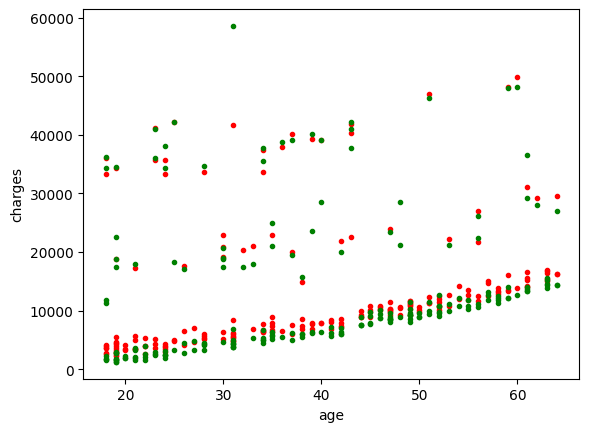

In [77]:
import matplotlib.pyplot as plt

#Charges = f ( age )
plt.xlabel("age")
plt.ylabel("charges")
plt.plot(X_test["age"], y_predicted, "r.")
plt.plot(X_test["age"], y_test, "g.")
plt.show()

Test supplémentaire

In [78]:
import pickle

export_object = model 

with open('serialized_model.pkl', 'wb') as writing_file:
    pickle.dump(export_object,writing_file)
